# Extending psyplot

This notebook demonstrates how psyplot can be extended with your own plotting scripts.

There are three ways that we demonstrate:

1. [the standard matplotlib approach](#1.-The-standard-matplotlib-approach)
2. [the _post_ formatoption approach](#2.-The-post-formatoption)
3. [the formatoption approach](#3.-The-formatoption-approach)

In [1]:
import psyplot.project as psy
import cartopy.feature as cf
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
psy.rcParams["plotter.maps.xgrid"] = False
psy.rcParams["plotter.maps.ygrid"] = False
psy.rcParams["plotter.plot2d.cmap"] = "viridis"

INFO:matplotlib.font_manager:generated new fontManager


We will demonstrate the different strategies with the functionality to add country boarders to the plot via cartopy. In a standard setting, this can be achieved pretty easily via `ax.add_feature(cf.BORDERS)`:

/home/circleci/miniconda3/envs/docs/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


/home/circleci/miniconda3/envs/docs/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


/home/circleci/miniconda3/envs/docs/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


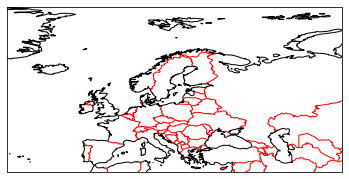

In [2]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-32, 69, 34, 81])  # focus on Europe
ax.add_feature(cf.BORDERS, color="red")

Our standard setting for psyplot would be something like

psyplot.project.Project([    arr0: 2-dim DataArray of t2m, with (lat, lon)=(96, 192), lev=100000.0, time=1979-01-31T18:00:00])

/home/circleci/miniconda3/envs/docs/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


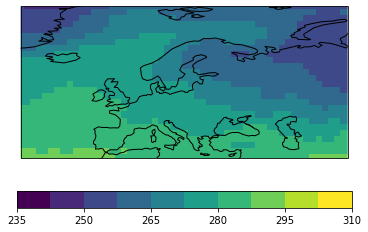

In [3]:
psy.plot.mapplot("demo.nc", name="t2m", map_extent="Europe")

## 1. The standard matplotlib approach

This the straight-forward approach that uses the fact that you can always access the matplotlib axes and run your own scripts. So we just combine the two steps from above:

/home/circleci/miniconda3/envs/docs/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


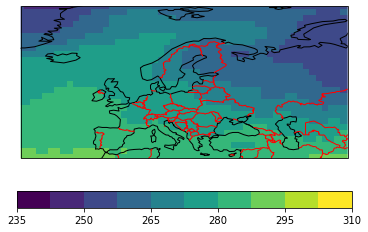

In [4]:
sp = psy.plot.mapplot("demo.nc", name="t2m", map_extent="Europe")
ax = sp.plotters[0].ax
ax.add_feature(cf.BORDERS, color="red")

### 1.1 Advantages:
- straight-forward matplotlib
- You do not have to interact with the psyplot framework at all

### 1.2 Disadvantages

#### 1.2.1. It does not benefit from the interactive psyplot framework

If you change your projection for instance, psyplot has to redraw the plot. See the following example where we change the projection of the basemap **after** the borders have been drawn.

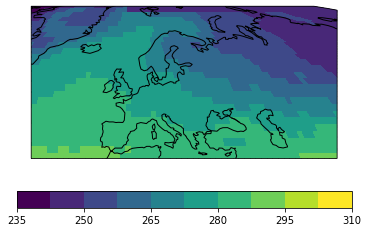

In [5]:
sp = psy.plot.mapplot("demo.nc", name="t2m", map_extent="Europe")
ax = sp.plotters[0].ax
ax.add_feature(cf.BORDERS, color="red")
sp.update(projection="moll")

Within the psyplot framework, we can encode when a feature in the plot needs to be drawn again. Changing the projection is a very expensive procedure. We first need to clear the axes and then regenerate the plot from scratch. As psyplot does not know anything about your _borders_, you have to rerun your script here.

#### 1.2.2. It results in copy-pasting

Adding country borders is a pretty simple task. But imagine you have a more challenging task for the visualization and you want to use this in many different scripts or even interactively via IPython. Then you need to copy-paste your code from one script to the other and this is not DRY (don't repeat yourself) at all.

## 2. The `post` formatoption

Another way that would be more psyplot-like is to use the `post` formatoption. You can find more about this [here](https://psyplot.github.io/examples/general/example_post.html).

You have two formatoptions for every plotter:

1. the `post` formatoption takes a script that is executed with the `post` formatoption itself as `self` (i.e. you can access the matplotlib axes via `self.ax` in your script
2. You can specify when your script is executed via the `post_timing` formatoption.

The plot above would be generated via 

/home/circleci/miniconda3/envs/docs/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


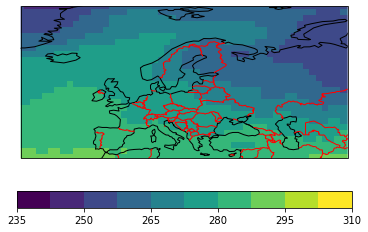

In [6]:
sp = psy.plot.mapplot(
    "demo.nc", name="t2m", map_extent="Europe",
    post="import cartopy.feature as cf; self.ax.add_feature(cf.BORDERS, color='red')",
    post_timing="replot",
    enable_post=True
)

### 2.1 Advantages

This way, you can use your standard matplotlib script (`self.ax.add_feature(cf.BORDERS)`) and still benefit from the interactivity via the `post_timing` formatoption.

Changing the projection, for instance, now also redraws the country borders

/home/circleci/miniconda3/envs/docs/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


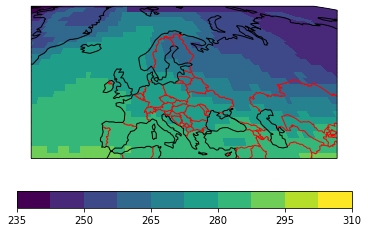

In [7]:
sp = psy.plot.mapplot(
    "demo.nc", name="t2m", map_extent="Europe",
    post="import cartopy.feature as cf; self.ax.add_feature(cf.BORDERS, color='red')",
    post_timing="replot",
    enable_post=True
)
sp.update(projection="moll")

### 2.2 Disadvantages

1. It's not very pythonic. The `post` formatoption takes python code and executes it via the built-in `exec` function. Using `exec` is always a security issue. This is why you have to explicitly allow the `post` formatoption with the `enable_post` argument in the call above.

2. You have to add your python code as string so you do not benefit from a lot of editor features, such as auto-completion, etc.

3. It's hard to change the style of the borders as you have to change the script that you pass to the `post` formatoption

## 3. The formatoption approach

The last approach here is the preferred method when you work with the psyplot framework. We generate our own formatoption and add it to the plotter. With this, we can make most out of the flexible and interactive framework, and we can easily reuse it across different scripts.

Formatoptions are just subclasses of the `psyplot.plotter.Formatoption`. We used a formatoption already with the `post` approach from above (the `self` is a formatoption). Our formatoption looks like:

In [8]:
from psyplot.plotter import Formatoption


class Borders(Formatoption):
    """Draw borders on a map"""
    
    default = False
    
    def validate(self, value):
        return bool(value)
    
    def update(self, value):
        if value:
            self.borders = self.ax.add_feature(cf.BORDERS, color="red")
        else:
            if hasattr(self, "borders"):
                self.borders.remove()
                del self.borders

This formatoption defines three important attributes:

1. `default`: The default value for the formatoption
2. `validate`: a validation method that validates and converts the value for the formatoption
3. `update`: the method that adds (or removes) the borders

Adding this formatoption to the `mapplot` plotmethod in psyplot is straight-forward. You just have to add it to the underlying plotter class that you can access via the `plotter_cls` attribute:

In [9]:
psy.plot.mapplot.plotter_cls.borders = Borders("borders")

Now you can draw borders via the `borders` formatoption:

/home/circleci/miniconda3/envs/docs/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


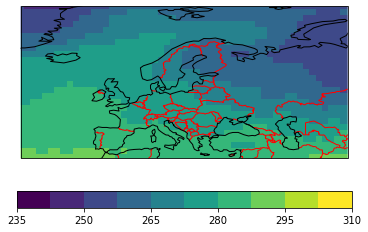

In [10]:
sp = psy.plot.mapplot("demo.nc", name="t2m", map_extent="Europe", borders=True)

and you can remove them via `borders=False`:

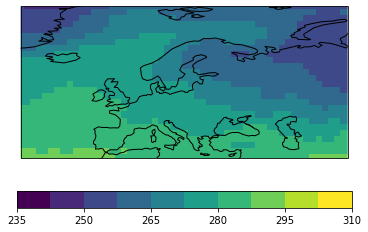

In [11]:
sp = psy.plot.mapplot("demo.nc", name="t2m", map_extent="Europe", borders=True)
sp.update(borders=False)

and you can profit from the interactivity of psyplot and change difficult aspects, such as the projection

/home/circleci/miniconda3/envs/docs/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


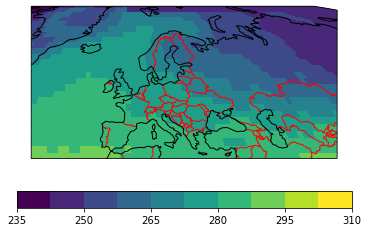

In [12]:
sp = psy.plot.mapplot("demo.nc", name="t2m", map_extent="Europe", borders=True)
sp.update(projection="moll")

### 3.1 Advantages

- Full compliance with the don't repeat yourself principle
- Uses the full flexibility of the psyplot framework
- You can easily save the formatoption to a script and import it when you need it
- You can create pull requests to psyplot and make your visualization methods available to others
- You can enhance your formatoption. Here we only accept `True` and `False` as a value, but you could also easily make your formatoption accept a dictionary with color or linewidth to the formatoption, e.g. 
`borders={"color": "red", "linewidths": 0.1})`.
- If you make sure that your formatoption is always compatible with the latest version of matplotlib, cartopy, etc. you automatically make sure that all of your plotting scripts are still compatible.

### 3.2 Disadvantages

You have to add a couple of lines of code.